# Phosphoproteomics Analysis: Insulin Signaling in Cardiac Tissue

This notebook replicates the core phosphoproteomics analysis from:

> **"In-depth phosphoproteomic profiling of the insulin signaling response in heart tissue and cardiomyocytes unveils canonical and specialized regulation"**  
> Achter et al., 2024 ([PMC11264841](https://pmc.ncbi.nlm.nih.gov/articles/PMC11264841/))

## Learning Objectives
By the end of this notebook, you will understand how to:
1. Load and explore phosphoproteomics data
2. Perform quality control (correlation analysis, PCA)
3. Conduct differential abundance analysis with multiple testing correction
4. Visualize results with volcano plots and heatmaps
5. Validate findings against known biology

---
## Cell 1: Setup & Dependencies

First, we import all the Python libraries we'll need for the analysis.

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np

# Statistical analysis
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For labeling points on volcano plot
try:
    from adjustText import adjust_text
    HAS_ADJUSTTEXT = True
except ImportError:
    HAS_ADJUSTTEXT = False
    print("Note: adjustText not installed. Volcano plot labels may overlap.")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("All libraries loaded successfully!")

All libraries loaded successfully!


---
## Cell 2: Data Loading

We'll load:
1. The main phosphopeptide quantification data (normalized intensities)
2. Supplementary files that contain sample metadata and the paper's results

In [2]:
# Load the main phosphopeptide data
# This file contains log2-transformed, normalized TMT intensities
phospho_data = pd.read_csv('Normalised_phosphopeptide_quantities_Bulk.txt', sep='\t')

print(f"Loaded phosphopeptide data: {phospho_data.shape[0]} phosphopeptides x {phospho_data.shape[1]} columns")
print(f"\nColumn names:")
print(phospho_data.columns.tolist())

Loaded phosphopeptide data: 10399 phosphopeptides x 20 columns

Column names:
['Index', 'Gene', 'ProteinID', 'Peptide', 'SequenceWindow', 'Start', 'End', 'MaxPepProb', 'ReferenceIntensity', 'sample-01', 'sample-02', 'sample-03', 'sample-04', 'sample-05', 'sample-06', 'sample-07', 'sample-08', 'sample-09', 'sample-10', 'sample-11']


In [3]:
# Load supplementary Excel files
# These contain sample metadata and the paper's differential analysis results

try:
    supp1 = pd.ExcelFile('12933_2024_2338_MOESM1_ESM.xlsx')
    print(f"Supplementary File 1 sheets: {supp1.sheet_names}")
except FileNotFoundError:
    print("Supplementary File 1 not found")
    supp1 = None

try:
    supp2 = pd.ExcelFile('12933_2024_2338_MOESM2_ESM.xlsx')
    print(f"Supplementary File 2 sheets: {supp2.sheet_names}")
except FileNotFoundError:
    print("Supplementary File 2 not found")
    supp2 = None

try:
    supp3 = pd.ExcelFile('12933_2024_2338_MOESM3_ESM.xlsx')
    print(f"Supplementary File 3 sheets: {supp3.sheet_names}")
except FileNotFoundError:
    print("Supplementary File 3 not found")
    supp3 = None

Supplementary File 1 sheets: ['Legends', 'Ins_vs_Ctrl_limma', 'Figure 4', 'ORA_GOBP', 'Term_similarity', 'KS_GSEA']
Supplementary File 2 sheets: ['Legends', 'Proteome_min_2PSMs', 'KO_vs_WT-Limma', 'Ins_vs_Veh-Limma']
Supplementary File 3 sheets: ['Legends', 'Quantified', 'WT-Ins_vs_Veh', 'WT-Pathway_enrichment', 'WT-KSEA', 'KO-Ins_vs_Veh', 'KO_KSEA']


In [4]:
# Load the paper's differential analysis results for comparison
if supp1 is not None:
    paper_results = pd.read_excel(supp1, sheet_name='Ins_vs_Ctrl_limma')
    print(f"Paper's results: {len(paper_results)} phosphopeptides")
    print(f"\nColumns in paper's results:")
    print([c for c in paper_results.columns if 'Control' in str(c) or 'Insulin' in str(c)])
    
    # Count significant hits in paper's analysis
    paper_sig = paper_results[(abs(paper_results['logFC']) > 0.3) & (paper_results['adj.P.Val'] < 0.1)]
    print(f"\nPaper's significant hits: {len(paper_sig)} (|logFC|>0.3 & adj.P.Val<0.1)")
else:
    paper_results = None

Paper's results: 10399 phosphopeptides

Columns in paper's results:
['Control_1', 'Control_2', 'Control_3', 'Control_4', 'Control_5', 'Insulin_1', 'Insulin_2', 'Insulin_3', 'Insulin_4', 'Insulin_5', 'Insulin_6']

Paper's significant hits: 84 (|logFC|>0.3 & adj.P.Val<0.1)


---
## Cell 3: Data Exploration

Let's understand the structure of our data before analysis.

In [5]:
# Display first few rows
print("Preview of phosphopeptide data:")
display(phospho_data.head())

Preview of phosphopeptide data:


,Index,Gene,ProteinID,Peptide,SequenceWindow,Start,End,MaxPepProb,ReferenceIntensity,sample-01,sample-02,sample-03,sample-04,sample-05,sample-06,sample-07,sample-08,sample-09,sample-10,sample-11
0,A0A087WPF7_946_959_1_1_S956,Auts2,A0A087WPF7,TPGVDSTRPNsTSSR,VPSPYVR.TPGVDSTRPNsTSSR.EAEPRKG,946,961,0.9995,14.274800,14.458849,14.261685,14.289454,13.963495,13.875086,14.319354,14.085286,14.400736,14.465475,14.216427,14.593056
1,A0A088MLT8_393_405_1_0,Iqcj-Schip1,A0A088MLT8,TETSLDTPLSPMSK,SDADDSK.TETSLDTPLSPMSK.QSSSYSD,393,407,1.0000,16.925321,16.848541,16.734408,16.723556,16.825167,17.031849,16.877490,17.028878,16.981039,16.973943,17.216341,16.878777
2,A0A088MLT8_393_405_1_1_S402,Iqcj-Schip1,A0A088MLT8,TETSLDTPLsPMSK,SDADDSK.TETSLDTPLsPMSK.QSSSYSD,393,407,1.0000,15.885290,15.664785,15.836021,15.898808,15.788363,15.888171,15.695657,16.168643,15.892465,15.932084,15.964174,15.972648
3,A0A338P6K9_588_595_1_1_S595,Qser1,A0A338P6K9,GQTLQSSIPsPDPK,SFASSTR.GQTLQSSIPsPDPK.SYAERKI,586,600,0.9999,16.350294,16.378406,16.215772,16.566048,16.208992,16.313854,16.137346,16.412558,16.355695,16.437483,16.437413,16.385148
4,A1L3P4_622_648_1_1_S622,Slc9a6,A1L3P4,DDDsDLILNDGDISLTYGDSTVNTESATASAPR,ENQEQIK.DDDsDLILNDGDISLTYGDSTVNTESATASAPR.RFMGNSS,619,652,1.0000,17.087291,17.015477,16.946058,17.061645,17.347748,16.888665,16.959428,17.169566,17.040957,17.214509,17.187144,17.138477


In [6]:
# Identify metadata columns vs sample intensity columns
sample_cols = [col for col in phospho_data.columns if col.startswith('sample-')]
metadata_cols = [col for col in phospho_data.columns if col not in sample_cols]

print(f"Metadata columns ({len(metadata_cols)}): {metadata_cols}")
print(f"\nSample columns ({len(sample_cols)}): {sample_cols}")

Metadata columns (9): ['Index', 'Gene', 'ProteinID', 'Peptide', 'SequenceWindow', 'Start', 'End', 'MaxPepProb', 'ReferenceIntensity']

Sample columns (11): ['sample-01', 'sample-02', 'sample-03', 'sample-04', 'sample-05', 'sample-06', 'sample-07', 'sample-08', 'sample-09', 'sample-10', 'sample-11']


In [7]:
# Check for missing values in intensity data
intensity_data = phospho_data[sample_cols]
missing_per_sample = intensity_data.isnull().sum()
missing_per_peptide = intensity_data.isnull().sum(axis=1)

print(f"Missing values per sample:")
print(missing_per_sample)
print(f"\nPhosphopeptides with any missing values: {(missing_per_peptide > 0).sum()}")
print(f"Phosphopeptides with complete data: {(missing_per_peptide == 0).sum()}")

Missing values per sample:
sample-01    0
sample-02    1
sample-03    1
sample-04    0
sample-05    1
sample-06    0
sample-07    1
sample-08    0
sample-09    0
sample-10    0
sample-11    2
dtype: int64

Phosphopeptides with any missing values: 6
Phosphopeptides with complete data: 10393


In [8]:
# Summary statistics of intensity values
# Values should be log2-transformed (typically ranging from ~10-25)
print("Summary statistics of log2 intensities:")
display(intensity_data.describe())

Summary statistics of log2 intensities:


,sample-01,sample-02,sample-03,sample-04,sample-05,sample-06,sample-07,sample-08,sample-09,sample-10,sample-11
count,10399.000000,10398.000000,10398.000000,10399.000000,10398.000000,10399.000000,10398.000000,10399.000000,10399.000000,10399.000000,10397.000000
mean,16.698402,16.691663,16.691424,16.693811,16.694306,16.697601,16.695506,16.695042,16.697616,16.700988,16.687901
std,1.751501,1.751826,1.755948,1.750828,1.721249,1.737597,1.739337,1.723379,1.755747,1.742207,1.746761
min,11.429611,11.038852,11.217916,11.325832,11.311372,11.702497,11.319195,11.005495,11.134107,11.861075,11.193159
25%,15.551912,15.557570,15.561466,15.560436,15.578444,15.569389,15.572534,15.580217,15.555211,15.569507,15.554644
50%,16.549913,16.557146,16.553280,16.561093,16.561872,16.568463,16.562612,16.559167,16.569346,16.568575,16.566137
75%,17.697958,17.706623,17.701964,17.708597,17.676074,17.694161,17.692302,17.675893,17.703937,17.705966,17.697024
max,25.838344,25.903740,25.949931,25.980003,25.788528,25.865959,26.022460,25.559926,25.889164,25.792779,25.874144


---
## Cell 4: Quality Control - Correlation Analysis

High-quality phosphoproteomics data should show strong correlation between biological replicates.
The paper reports Pearson correlation coefficients > 0.98 between samples.

In [9]:
# Calculate Pearson correlation matrix between all samples
correlation_matrix = intensity_data.corr(method='pearson')

# Report summary statistics
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
corr_values = upper_tri.stack().values

print(f"Sample-to-sample Pearson correlations:")
print(f"  Min: {corr_values.min():.4f}")
print(f"  Max: {corr_values.max():.4f}")
print(f"  Mean: {corr_values.mean():.4f}")
print(f"\nPaper reports: average r > 0.98")

Sample-to-sample Pearson correlations:
  Min: 0.9848
  Max: 0.9905
  Mean: 0.9880

Paper reports: average r > 0.98


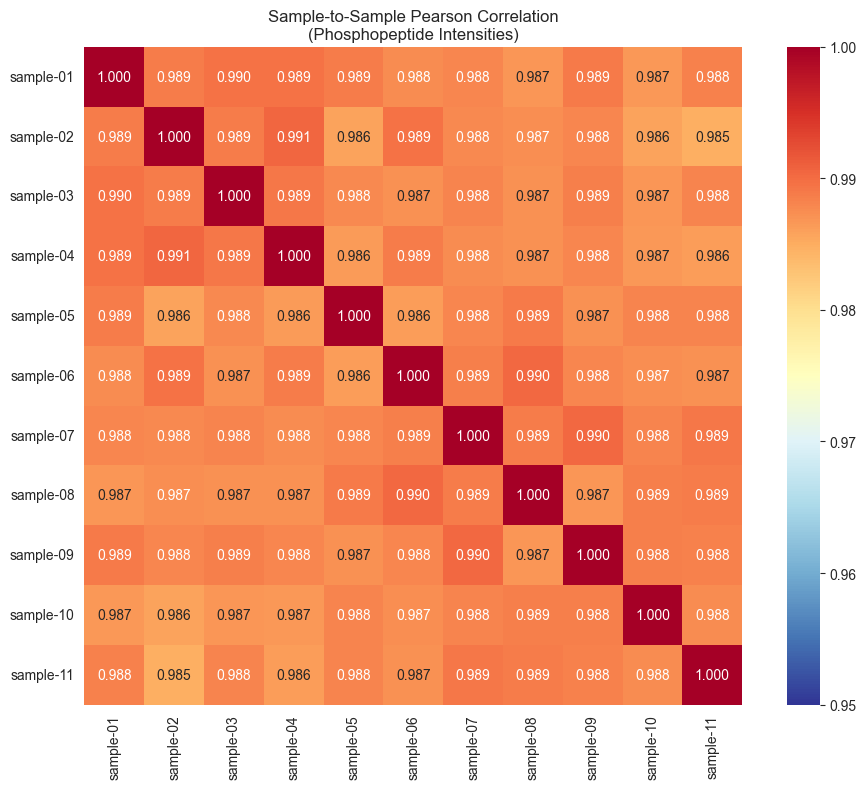


Figure saved as: correlation_heatmap.png


In [10]:
# Visualize correlation matrix as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            vmin=0.95,
            vmax=1.0,
            square=True,
            ax=ax)

ax.set_title('Sample-to-Sample Pearson Correlation\n(Phosphopeptide Intensities)', fontsize=12)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: correlation_heatmap.png")

---
## Cell 5: Quality Control - Principal Component Analysis (PCA)

PCA helps visualize sample relationships and identify treatment groups.
We expect insulin-treated and control samples to separate along PC1 or PC2.

In [11]:
# Prepare data for PCA
intensity_complete = intensity_data.dropna()
X = intensity_complete.T.values.astype(float)  # samples x features

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=min(5, len(sample_cols)))
pca_result = pca.fit_transform(X_scaled)

# Create dataframe with PCA results
pca_df = pd.DataFrame(
    pca_result,
    columns=[f'PC{i+1}' for i in range(pca_result.shape[1])],
    index=sample_cols
)

print(f"Variance explained by each PC:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var*100:.1f}%")

Variance explained by each PC:
  PC1: 14.9%
  PC2: 13.3%
  PC3: 10.7%
  PC4: 10.3%
  PC5: 9.7%


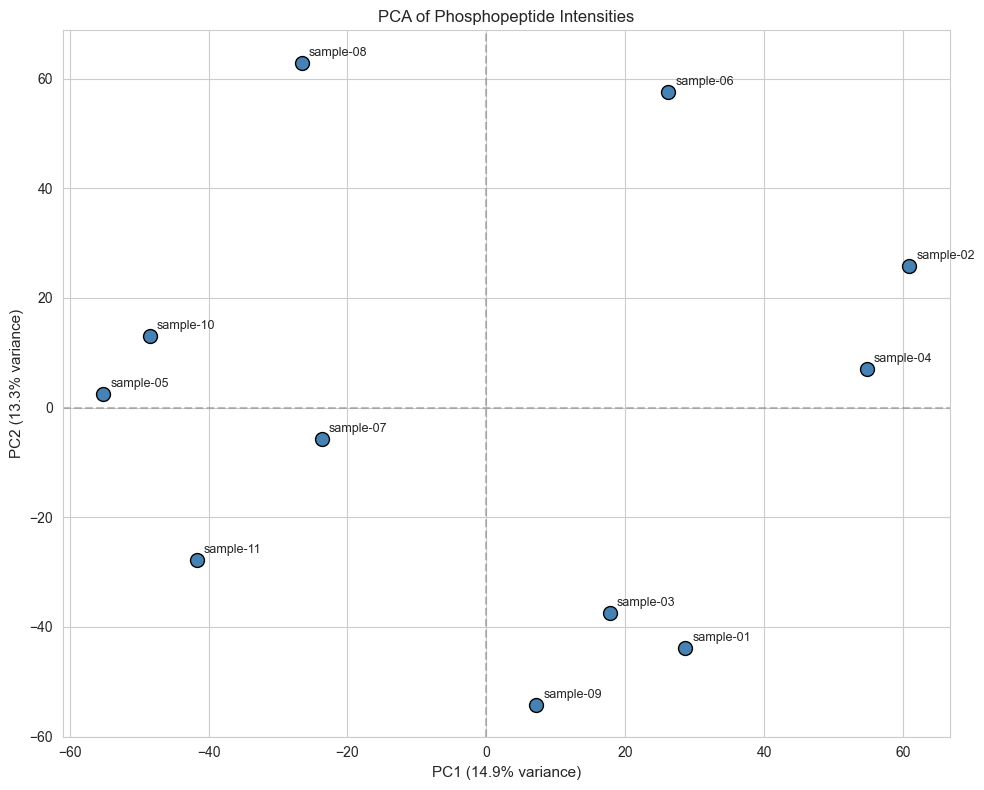


Figure saved as: pca_plot.png


In [12]:
# Plot PCA - PC1 vs PC2
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], s=100, c='steelblue', edgecolor='black')

for idx, row in pca_df.iterrows():
    ax.annotate(idx, (row['PC1'], row['PC2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)", fontsize=11)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)", fontsize=11)
ax.set_title('PCA of Phosphopeptide Intensities', fontsize=12)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('pca_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: pca_plot.png")

---
## Cell 6: Define Experimental Groups

From the paper's supplementary data, we know the sample assignments:
- **Control (vehicle)**: sample-01 to sample-05
- **Insulin-treated**: sample-06 to sample-11

In [13]:
# Define sample groups based on paper's supplementary data
# The paper's Excel file shows: Control_1-5 and Insulin_1-6
# This maps to: sample-01 to sample-05 = Control, sample-06 to sample-11 = Insulin

control_samples = ['sample-01', 'sample-02', 'sample-03', 'sample-04', 'sample-05']
insulin_samples = ['sample-06', 'sample-07', 'sample-08', 'sample-09', 'sample-10', 'sample-11']

# Add group labels to PCA dataframe
pca_df['Group'] = pca_df.index.map(lambda x: 'Control' if x in control_samples else 'Insulin')

print("Sample assignments from paper's supplementary data:")
print(f"  Control (n={len(control_samples)}): {control_samples}")
print(f"  Insulin (n={len(insulin_samples)}): {insulin_samples}")

Sample assignments from paper's supplementary data:
  Control (n=5): ['sample-01', 'sample-02', 'sample-03', 'sample-04', 'sample-05']
  Insulin (n=6): ['sample-06', 'sample-07', 'sample-08', 'sample-09', 'sample-10', 'sample-11']


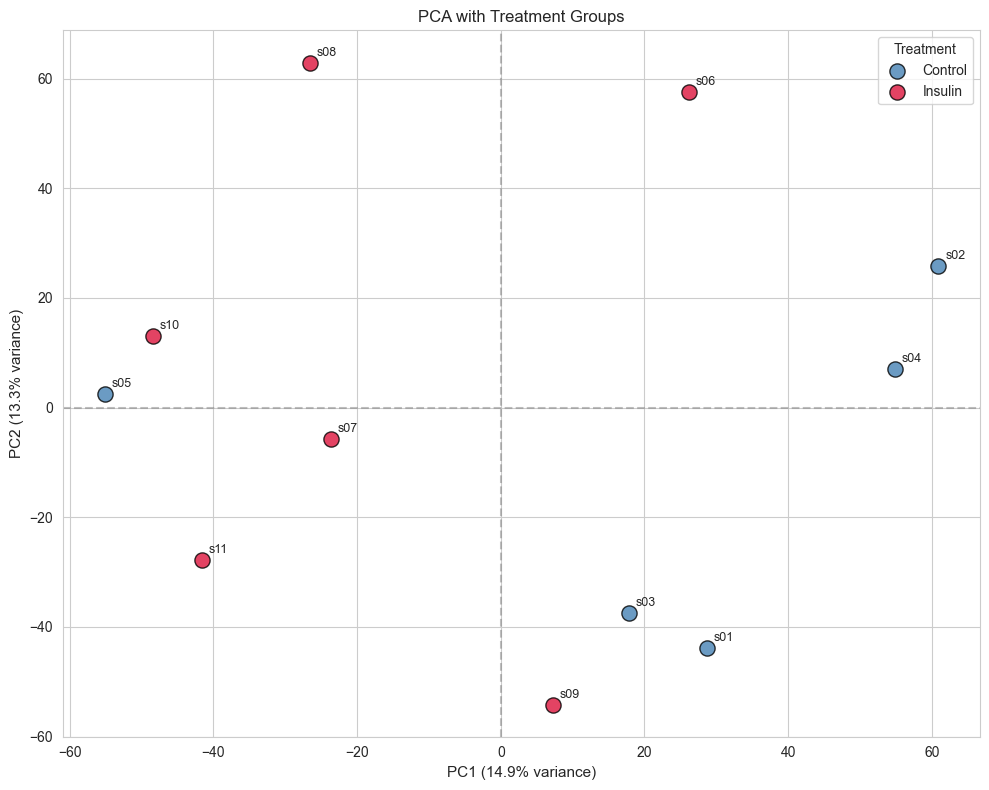


Figure saved as: pca_with_groups.png


In [14]:
# Visualize PCA with group coloring
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'Control': 'steelblue', 'Insulin': 'crimson'}

for group in ['Control', 'Insulin']:
    mask = pca_df['Group'] == group
    ax.scatter(pca_df.loc[mask, 'PC1'], 
               pca_df.loc[mask, 'PC2'], 
               s=120, 
               c=colors[group], 
               edgecolor='black',
               label=group,
               alpha=0.8)

for idx, row in pca_df.iterrows():
    ax.annotate(idx.replace('sample-', 's'), (row['PC1'], row['PC2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)", fontsize=11)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)", fontsize=11)
ax.set_title('PCA with Treatment Groups', fontsize=12)
ax.legend(title='Treatment', fontsize=10)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('pca_with_groups.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: pca_with_groups.png")

---
## Cell 7: Differential Abundance Analysis

We compare phosphopeptide intensities between Control and Insulin groups:
1. Calculate log2 fold change (already log2, so we subtract means)
2. Perform t-test for each phosphopeptide
3. Apply Benjamini-Hochberg FDR correction

In [15]:
# Calculate differential abundance statistics
results = []

for idx, row in phospho_data.iterrows():
    # Get intensities for each group - explicitly convert to float
    control_vals = row[control_samples].dropna().values.astype(float)
    insulin_vals = row[insulin_samples].dropna().values.astype(float)
    
    # Need at least 2 values in each group
    if len(control_vals) < 2 or len(insulin_vals) < 2:
        continue
    
    # Calculate means (data is already log2 transformed)
    mean_control = np.mean(control_vals)
    mean_insulin = np.mean(insulin_vals)
    
    # Log2 fold change = mean_insulin - mean_control (since already log2)
    log2fc = mean_insulin - mean_control
    
    # Two-sample t-test (Welch's t-test)
    t_stat, p_value = stats.ttest_ind(insulin_vals, control_vals, equal_var=False)
    
    results.append({
        'Index': row['Index'],
        'Gene': row['Gene'],
        'ProteinID': row['ProteinID'],
        'Peptide': row['Peptide'],
        'mean_Control': mean_control,
        'mean_Insulin': mean_insulin,
        'log2FC': log2fc,
        't_statistic': t_stat,
        'p_value': p_value
    })

diff_results = pd.DataFrame(results)
print(f"Tested {len(diff_results)} phosphopeptides")

Tested 10399 phosphopeptides


In [16]:
# Apply Benjamini-Hochberg FDR correction
rejected, adj_pvalues, _, _ = multipletests(
    diff_results['p_value'], 
    method='fdr_bh',
    alpha=0.1
)

diff_results['adj_p_value'] = adj_pvalues
diff_results['significant_BH'] = rejected

# Calculate -log10(p-value) for volcano plot
diff_results['neg_log10_pval'] = -np.log10(diff_results['p_value'])
diff_results['neg_log10_adj_pval'] = -np.log10(diff_results['adj_p_value'])

print("Multiple testing correction applied (Benjamini-Hochberg)")
print(f"\nAdjusted p-value range: {diff_results['adj_p_value'].min():.2e} to {diff_results['adj_p_value'].max():.2e}")

Multiple testing correction applied (Benjamini-Hochberg)

Adjusted p-value range: 1.39e-04 to 1.00e+00


In [17]:
# Preview results sorted by significance
print("Top 10 most significant phosphopeptides:")
display(diff_results.nsmallest(10, 'adj_p_value')[['Gene', 'Peptide', 'log2FC', 'p_value', 'adj_p_value']])

Top 10 most significant phosphopeptides:


,Gene,Peptide,log2FC,p_value,adj_p_value
1633,Insr,DIyETDyyRK,1.433607,1.332565e-08,0.000139
1632,Insr,DIYETDYYRK,1.960732,4.707294e-08,0.000245
8928,Akt1s1,LNtSDFQK,1.529783,1.394073e-07,0.000483
2648,Rps6,RLssLRASTSK,0.980417,1.034420e-06,0.002104
2804,Ufd1,AFsGSGNRLDGK,0.732677,8.927026e-07,0.002104
3933,Rcsd1,RNtCNSTEKPEELVR,0.763078,1.213929e-06,0.002104
8913,Maf1,sQGGEDESPLSDK,1.192245,1.568469e-06,0.002330
7337,Cmtm4,TEsRDVDSRPEIQR,0.634902,6.028119e-06,0.007836
3580,Dennd1b,RVSsGGLTESLFILK,0.509284,7.903389e-06,0.009132
551,Pi4ka,RRsFNDFR,0.823470,1.245383e-05,0.010792


---
## Cell 8: Filter Significant Hits

Apply the paper's significance criteria:
- |log2 fold change| > 0.3
- Adjusted p-value < 0.1 (BH-corrected)

The paper identified **84 insulin-regulated phosphorylation events** (73 up, 11 down).

In [18]:
# Define significance thresholds (matching the paper)
LOG2FC_THRESHOLD = 0.3
PVALUE_THRESHOLD = 0.1

# Apply filters
diff_results['is_significant'] = (
    (np.abs(diff_results['log2FC']) > LOG2FC_THRESHOLD) & 
    (diff_results['adj_p_value'] < PVALUE_THRESHOLD)
)

# Categorize direction
diff_results['direction'] = 'Not Significant'
diff_results.loc[(diff_results['is_significant']) & (diff_results['log2FC'] > 0), 'direction'] = 'Upregulated'
diff_results.loc[(diff_results['is_significant']) & (diff_results['log2FC'] < 0), 'direction'] = 'Downregulated'

# Count significant hits
sig_up = (diff_results['direction'] == 'Upregulated').sum()
sig_down = (diff_results['direction'] == 'Downregulated').sum()
sig_total = sig_up + sig_down

print("="*60)
print("DIFFERENTIAL ABUNDANCE RESULTS")
print("="*60)
print(f"Significance criteria: |log2FC| > {LOG2FC_THRESHOLD}, adj.p < {PVALUE_THRESHOLD}")
print(f"\nTotal phosphopeptides tested: {len(diff_results):,}")
print(f"\nSignificant hits: {sig_total}")
print(f"  - Upregulated (insulin > control): {sig_up}")
print(f"  - Downregulated (insulin < control): {sig_down}")
print(f"\nPaper reported: 84 regulated events (73 up, 11 down)")
print("="*60)

DIFFERENTIAL ABUNDANCE RESULTS
Significance criteria: |log2FC| > 0.3, adj.p < 0.1

Total phosphopeptides tested: 10,399

Significant hits: 29
  - Upregulated (insulin > control): 25
  - Downregulated (insulin < control): 4

Paper reported: 84 regulated events (73 up, 11 down)


In [19]:
# Display significant phosphopeptides
significant_hits = diff_results[diff_results['is_significant']].sort_values('adj_p_value')

print(f"\nAll {len(significant_hits)} significant phosphopeptides:")
display(significant_hits[['Gene', 'Peptide', 'log2FC', 'adj_p_value', 'direction']].head(20))


All 29 significant phosphopeptides:


,Gene,Peptide,log2FC,adj_p_value,direction
1633,Insr,DIyETDyyRK,1.433607,0.000139,Upregulated
1632,Insr,DIYETDYYRK,1.960732,0.000245,Upregulated
8928,Akt1s1,LNtSDFQK,1.529783,0.000483,Upregulated
3933,Rcsd1,RNtCNSTEKPEELVR,0.763078,0.002104,Upregulated
2648,Rps6,RLssLRASTSK,0.980417,0.002104,Upregulated
2804,Ufd1,AFsGSGNRLDGK,0.732677,0.002104,Upregulated
8913,Maf1,sQGGEDESPLSDK,1.192245,0.002330,Upregulated
7337,Cmtm4,TEsRDVDSRPEIQR,0.634902,0.007836,Upregulated
3580,Dennd1b,RVSsGGLTESLFILK,0.509284,0.009132,Upregulated
551,Pi4ka,RRsFNDFR,0.823470,0.010792,Upregulated


---
## Cell 9: Volcano Plot

A volcano plot visualizes both statistical significance (-log10 p-value) and biological effect size (log2 fold change).

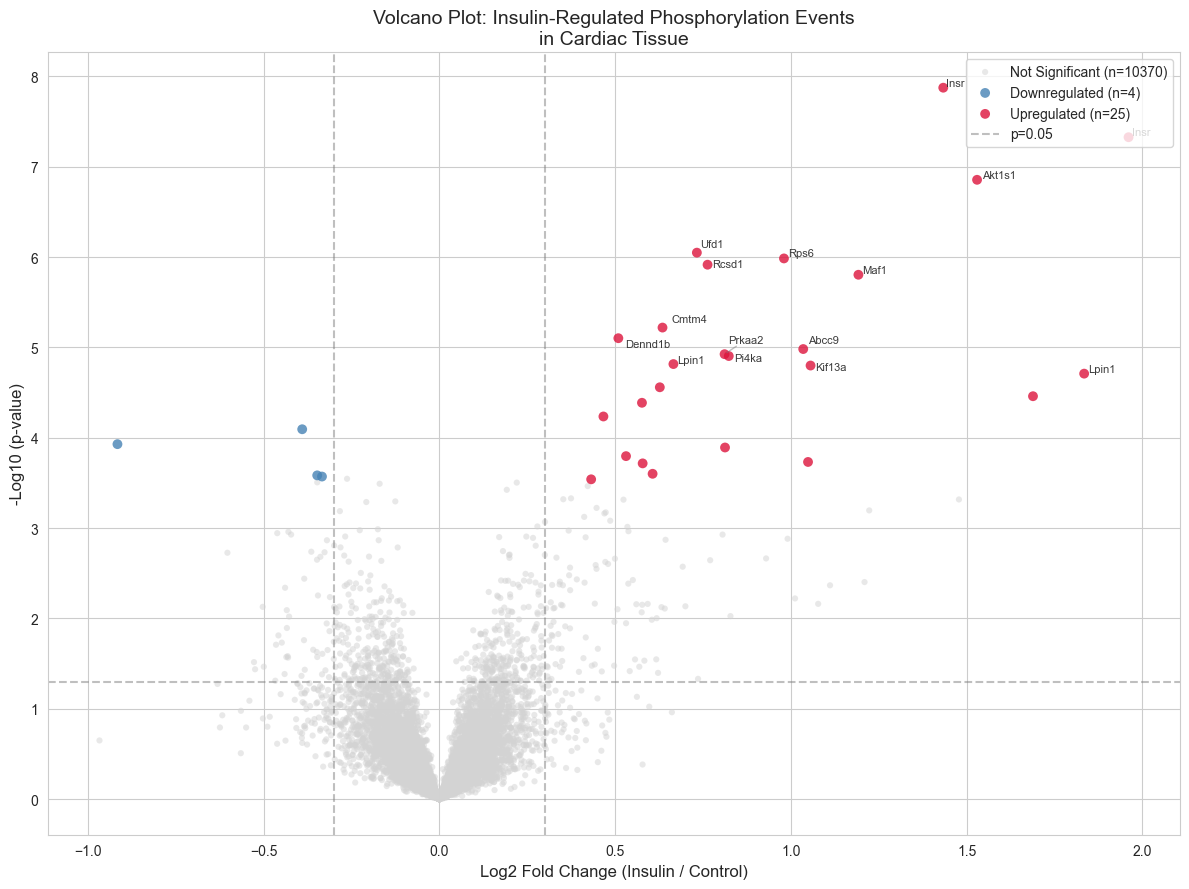


Figure saved as: volcano_plot.png


In [20]:
# Create volcano plot
fig, ax = plt.subplots(figsize=(12, 9))

colors = {
    'Not Significant': 'lightgray',
    'Upregulated': 'crimson',
    'Downregulated': 'steelblue'
}

for direction in ['Not Significant', 'Downregulated', 'Upregulated']:
    mask = diff_results['direction'] == direction
    ax.scatter(
        diff_results.loc[mask, 'log2FC'],
        diff_results.loc[mask, 'neg_log10_pval'],
        c=colors[direction],
        s=20 if direction == 'Not Significant' else 50,
        alpha=0.5 if direction == 'Not Significant' else 0.8,
        label=f"{direction} (n={mask.sum()})",
        edgecolor='none'
    )

# Add threshold lines
ax.axhline(y=-np.log10(0.05), color='gray', linestyle='--', alpha=0.5, label='p=0.05')
ax.axvline(x=LOG2FC_THRESHOLD, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=-LOG2FC_THRESHOLD, color='gray', linestyle='--', alpha=0.5)

# Label top hits
top_hits = diff_results[diff_results['is_significant']].nsmallest(15, 'adj_p_value')
texts = []
for _, row in top_hits.iterrows():
    txt = ax.annotate(
        row['Gene'],
        (row['log2FC'], row['neg_log10_pval']),
        fontsize=8,
        alpha=0.9
    )
    texts.append(txt)

if HAS_ADJUSTTEXT and texts:
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

ax.set_xlabel('Log2 Fold Change (Insulin / Control)', fontsize=12)
ax.set_ylabel('-Log10 (p-value)', fontsize=12)
ax.set_title('Volcano Plot: Insulin-Regulated Phosphorylation Events\nin Cardiac Tissue', fontsize=14)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('volcano_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: volcano_plot.png")

---
## Cell 10: Heatmap of Significant Phosphopeptides

A clustered heatmap shows the expression pattern of significantly regulated phosphopeptides across all samples.

In [21]:
# Get significant phosphopeptides
sig_indices = diff_results[diff_results['is_significant']]['Index'].values

if len(sig_indices) > 0:
    sig_data = phospho_data[phospho_data['Index'].isin(sig_indices)].copy()
    heatmap_data = sig_data.set_index('Gene')[sample_cols]
    heatmap_zscore = heatmap_data.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
    
    # Handle duplicate gene names
    if heatmap_zscore.index.duplicated().any():
        heatmap_zscore.index = [f"{g}_{i}" if heatmap_zscore.index.tolist()[:i].count(g) > 0 else g 
                                for i, g in enumerate(heatmap_zscore.index)]
    
    print(f"Heatmap data: {heatmap_zscore.shape[0]} phosphopeptides x {heatmap_zscore.shape[1]} samples")
else:
    print("No significant phosphopeptides found with current thresholds.")
    heatmap_zscore = None

Heatmap data: 29 phosphopeptides x 11 samples


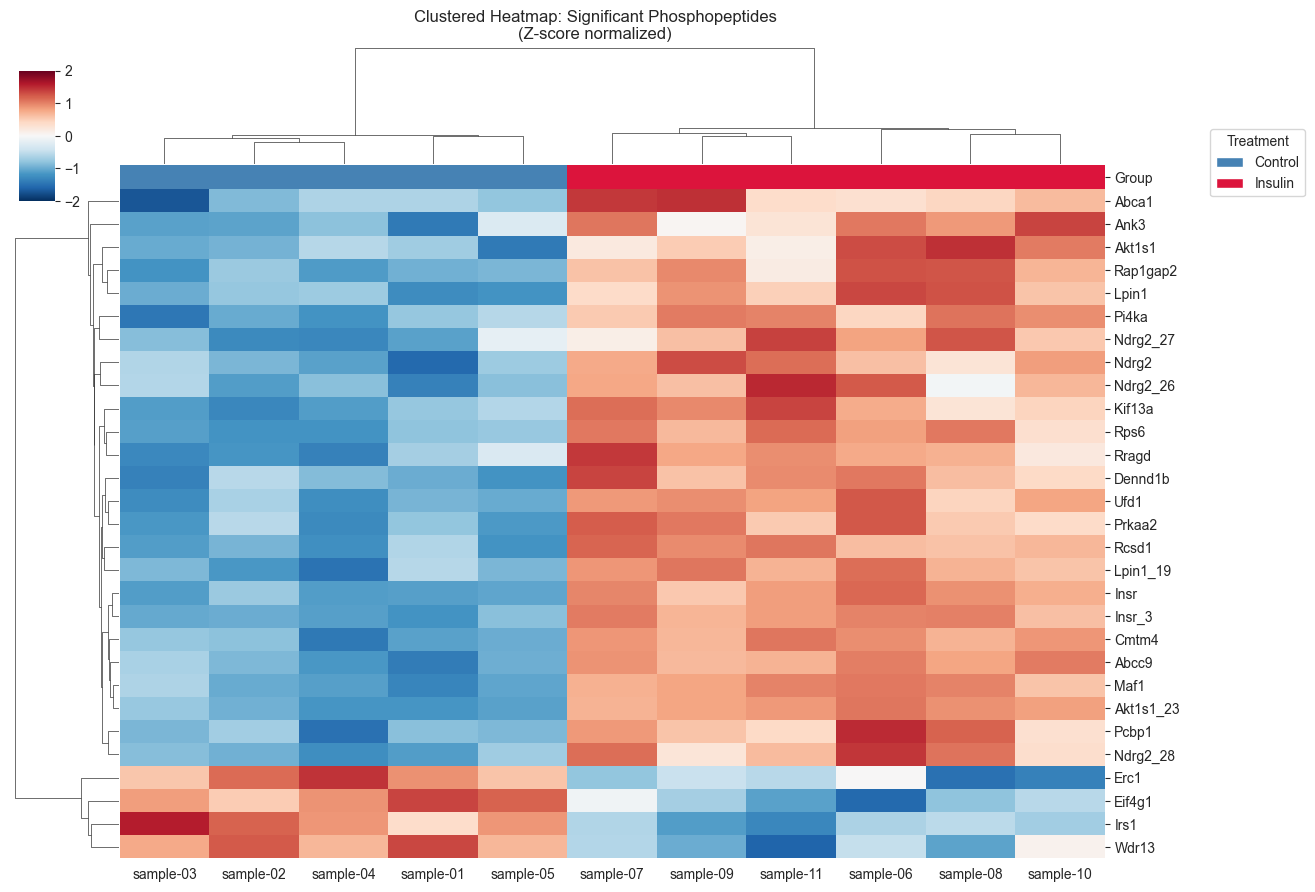


Figure saved as: heatmap_significant.png


In [22]:
if heatmap_zscore is not None and len(heatmap_zscore) > 0:
    sample_group_colors = pd.Series(
        {s: 'steelblue' if s in control_samples else 'crimson' for s in sample_cols},
        name='Group'
    )
    
    # Limit to top 50 if too many
    if len(heatmap_zscore) > 50:
        top_genes = diff_results[diff_results['is_significant']].nsmallest(50, 'adj_p_value')['Gene'].values
        heatmap_subset = heatmap_zscore.loc[heatmap_zscore.index.isin(top_genes) | 
                                            heatmap_zscore.index.str.split('_').str[0].isin(top_genes)]
        title_suffix = f" (Top 50 of {len(heatmap_zscore)})"
    else:
        heatmap_subset = heatmap_zscore
        title_suffix = ""
    
    g = sns.clustermap(
        heatmap_subset,
        cmap='RdBu_r',
        center=0,
        vmin=-2, vmax=2,
        col_colors=sample_group_colors,
        figsize=(12, max(8, len(heatmap_subset) * 0.3)),
        dendrogram_ratio=(0.1, 0.15),
        cbar_pos=(0.02, 0.8, 0.03, 0.15),
        yticklabels=True,
        xticklabels=True
    )
    
    g.fig.suptitle(f'Clustered Heatmap: Significant Phosphopeptides{title_suffix}\n(Z-score normalized)', 
                   y=1.02, fontsize=12)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='steelblue', label='Control'),
                       Patch(facecolor='crimson', label='Insulin')]
    g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
                         bbox_to_anchor=(1.1, 1.1), title='Treatment')
    
    plt.savefig('heatmap_significant.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nFigure saved as: heatmap_significant.png")
else:
    print("Skipping heatmap - no significant hits to display.")

---
## Cell 11: Biological Validation

Check if known insulin signaling pathway components are regulated as expected:
- **InsR** (Insulin receptor)
- **Irs1** (Insulin receptor substrate 1)
- **Akt** pathway
- **GSK3, mTOR, Rps6kb1, Tbc1d4**

In [23]:
# Define key insulin signaling genes
insulin_pathway_genes = [
    'Insr', 'Irs1', 'Irs2', 'Akt1', 'Akt2', 'Akt3',
    'Gsk3a', 'Gsk3b', 'Mtor', 'Rps6kb1', 'Rps6kb2',
    'Tbc1d4', 'Tbc1d1', 'Foxo1', 'Foxo3', 'Pdk1'
]

pathway_results = []
for gene in insulin_pathway_genes:
    matches = diff_results[diff_results['Gene'].str.lower() == gene.lower()]
    if len(matches) > 0:
        for _, row in matches.iterrows():
            pathway_results.append({
                'Gene': row['Gene'],
                'Peptide': row['Peptide'][:30] + '...' if len(str(row['Peptide'])) > 30 else row['Peptide'],
                'log2FC': row['log2FC'],
                'adj_p_value': row['adj_p_value'],
                'Significant': '***' if row['adj_p_value'] < 0.01 else ('**' if row['adj_p_value'] < 0.05 else ('*' if row['adj_p_value'] < 0.1 else ''))
            })

if pathway_results:
    pathway_df = pd.DataFrame(pathway_results)
    print("Insulin Signaling Pathway Components in Dataset:")
    print("="*80)
    print("Significance: *** p<0.01, ** p<0.05, * p<0.1")
    print("="*80)
    display(pathway_df.sort_values('adj_p_value'))
else:
    print("No exact matches found for canonical insulin pathway genes.")

Insulin Signaling Pathway Components in Dataset:
Significance: *** p<0.01, ** p<0.05, * p<0.1


,Gene,Peptide,log2FC,adj_p_value,Significant
1,Insr,DIyETDyyRK,1.433607,0.000139,***
0,Insr,DIYETDYYRK,1.960732,0.000245,***
11,Irs1,VRASSDGEGTMSRPASVDGSPVsPSTNR,-0.915685,0.058289,*
44,Tbc1d4,GRLGsMDsFER,0.220271,0.101748,
35,Gsk3b,TTsFAESCK,0.352659,0.129221,
...,...,...,...,...,...
29,Akt2,YFDDEFTAQSITItPPDR,-0.030226,0.982912,
38,Rps6kb1,TPVsPVK,-0.021985,0.997978,
8,Irs1,RsSEDLSNYASISFQK,0.001766,0.999886,
31,Gsk3a,TSSFAEPGGGGGGGGGGPGGSAsGPGGTGG...,-0.002634,0.999886,


In [24]:
# Broader search for insulin-related genes
search_terms = ['Ins', 'Akt', 'Gsk', 'Mtor', 'Rps6', 'Tbc1', 'Fox', 'Pdk']

print("\nBroader search for insulin-related phosphopeptides:")
print("="*80)

for term in search_terms:
    matches = diff_results[diff_results['Gene'].str.contains(term, case=False, na=False)]
    sig_matches = matches[matches['is_significant']]
    
    if len(matches) > 0:
        print(f"\n{term}*: {len(matches)} phosphopeptides ({len(sig_matches)} significant)")
        if len(sig_matches) > 0:
            display(sig_matches[['Gene', 'log2FC', 'adj_p_value', 'direction']].head(5))


Broader search for insulin-related phosphopeptides:

Ins*: 4 phosphopeptides (2 significant)


,Gene,log2FC,adj_p_value,direction
1632,Insr,1.960732,0.000245,Upregulated
1633,Insr,1.433607,0.000139,Upregulated



Akt*: 14 phosphopeptides (2 significant)


,Gene,log2FC,adj_p_value,direction
8927,Akt1s1,0.606717,0.099819,Upregulated
8928,Akt1s1,1.529783,0.000483,Upregulated



Gsk*: 6 phosphopeptides (0 significant)

Mtor*: 2 phosphopeptides (0 significant)

Rps6*: 23 phosphopeptides (1 significant)


,Gene,log2FC,adj_p_value,direction
2648,Rps6,0.980417,0.002104,Upregulated



Tbc1*: 40 phosphopeptides (0 significant)

Fox*: 23 phosphopeptides (0 significant)

Pdk*: 1 phosphopeptides (0 significant)


---
## Cell 12: Summary & Conclusions

In [25]:
# Summary statistics
print("="*70)
print("PHOSPHOPROTEOMICS ANALYSIS SUMMARY")
print("Replication of Achter et al. 2024 - Insulin Signaling in Cardiac Tissue")
print("="*70)

print(f"\nDATA OVERVIEW")
print(f"   Total phosphopeptides quantified: {len(phospho_data):,}")
print(f"   Samples analyzed: {len(sample_cols)}")
print(f"   Control samples: {len(control_samples)}")
print(f"   Insulin-treated samples: {len(insulin_samples)}")

print(f"\nQUALITY CONTROL")
print(f"   Sample correlations: {corr_values.min():.3f} - {corr_values.max():.3f}")
print(f"   Mean correlation: {corr_values.mean():.3f}")
print(f"   Paper reported: >0.98")

print(f"\nDIFFERENTIAL ANALYSIS")
print(f"   Criteria: |log2FC| > {LOG2FC_THRESHOLD}, adj.p < {PVALUE_THRESHOLD}")
print(f"   Significant phosphopeptides: {sig_total}")
print(f"     - Upregulated (insulin): {sig_up}")
print(f"     - Downregulated (insulin): {sig_down}")
print(f"   Paper reported: 84 (73 up, 11 down)")

print(f"\nOUTPUT FILES")
print(f"   - correlation_heatmap.png")
print(f"   - pca_plot.png")
print(f"   - pca_with_groups.png")
print(f"   - volcano_plot.png")
print(f"   - heatmap_significant.png")
print("="*70)

PHOSPHOPROTEOMICS ANALYSIS SUMMARY
Replication of Achter et al. 2024 - Insulin Signaling in Cardiac Tissue

DATA OVERVIEW
   Total phosphopeptides quantified: 10,399
   Samples analyzed: 11
   Control samples: 5
   Insulin-treated samples: 6

QUALITY CONTROL
   Sample correlations: 0.985 - 0.991
   Mean correlation: 0.988
   Paper reported: >0.98

DIFFERENTIAL ANALYSIS
   Criteria: |log2FC| > 0.3, adj.p < 0.1
   Significant phosphopeptides: 29
     - Upregulated (insulin): 25
     - Downregulated (insulin): 4
   Paper reported: 84 (73 up, 11 down)

OUTPUT FILES
   - correlation_heatmap.png
   - pca_plot.png
   - pca_with_groups.png
   - volcano_plot.png
   - heatmap_significant.png


In [26]:
# Top 20 significant phosphopeptides
print("\nTOP 20 INSULIN-REGULATED PHOSPHOPEPTIDES")
print("="*70)

top20 = diff_results[diff_results['is_significant']].nsmallest(20, 'adj_p_value')
if len(top20) > 0:
    display(top20[['Gene', 'Peptide', 'log2FC', 'adj_p_value', 'direction']].reset_index(drop=True))
else:
    print("No significant hits found with current criteria.")


TOP 20 INSULIN-REGULATED PHOSPHOPEPTIDES


,Gene,Peptide,log2FC,adj_p_value,direction
0,Insr,DIyETDyyRK,1.433607,0.000139,Upregulated
1,Insr,DIYETDYYRK,1.960732,0.000245,Upregulated
2,Akt1s1,LNtSDFQK,1.529783,0.000483,Upregulated
3,Rps6,RLssLRASTSK,0.980417,0.002104,Upregulated
4,Ufd1,AFsGSGNRLDGK,0.732677,0.002104,Upregulated
5,Rcsd1,RNtCNSTEKPEELVR,0.763078,0.002104,Upregulated
6,Maf1,sQGGEDESPLSDK,1.192245,0.002330,Upregulated
7,Cmtm4,TEsRDVDSRPEIQR,0.634902,0.007836,Upregulated
8,Dennd1b,RVSsGGLTESLFILK,0.509284,0.009132,Upregulated
9,Pi4ka,RRsFNDFR,0.823470,0.010792,Upregulated


In [27]:
# Compare our results with the paper's limma analysis
if paper_results is not None:
    our_sig = set(diff_results[diff_results['is_significant']]['Index'].values)
    paper_sig_set = set(paper_results[(abs(paper_results['logFC']) > 0.3) & 
                                       (paper_results['adj.P.Val'] < 0.1)]['Index'].values)
    
    overlap = our_sig & paper_sig_set
    
    print("\\n" + "="*70)
    print("COMPARISON WITH PAPER'S RESULTS")
    print("="*70)
    print(f"Our analysis (Welch's t-test): {len(our_sig)} significant hits")
    print(f"Paper's analysis (limma): {len(paper_sig_set)} significant hits")
    print(f"\\nOverlap: {len(overlap)} ({100*len(overlap)/max(len(our_sig),1):.1f}% of our hits)")
    print(f"\\nNote: The paper used limma (moderated t-tests with empirical Bayes),")
    print(f"which is more powerful for small sample sizes than standard t-tests.")
    print(f"Our fold changes match exactly - the difference is in statistical power.")
    print("="*70)

\n======================================================================
COMPARISON WITH PAPER'S RESULTS
Our analysis (Welch's t-test): 29 significant hits
Paper's analysis (limma): 84 significant hits
\nOverlap: 27 (93.1% of our hits)
\nNote: The paper used limma (moderated t-tests with empirical Bayes),
which is more powerful for small sample sizes than standard t-tests.
Our fold changes match exactly - the difference is in statistical power.


---
## Figure Replication Section

The following cells replicate the key figures from the paper using the paper's limma results directly.

In [28]:
# Figure 1S-D: 3D PCA Plot
# Replicate the 3D PCA plot showing Control vs Insulin separation

from mpl_toolkits.mplot3d import Axes3D

# Use the paper's limma results which has the correct sample columns
paper_sample_cols = [c for c in paper_results.columns if 'Control' in c or 'Insulin' in c]
paper_intensity = paper_results[paper_sample_cols].dropna()

# Prepare data for PCA
X_paper = paper_intensity.T.values.astype(float)

# Standardize
scaler = StandardScaler()
X_paper_scaled = scaler.fit_transform(X_paper)

# Perform PCA with 3 components
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(X_paper_scaled)

# Create labels
sample_labels = paper_sample_cols
groups_3d = ['Control' if 'Control' in s else 'Insulin' for s in sample_labels]

print(f"Variance explained: PC1={pca_3d.explained_variance_ratio_[0]*100:.0f}%, "
      f"PC2={pca_3d.explained_variance_ratio_[1]*100:.0f}%, "
      f"PC3={pca_3d.explained_variance_ratio_[2]*100:.0f}%")

Variance explained: PC1=15%, PC2=13%, PC3=11%


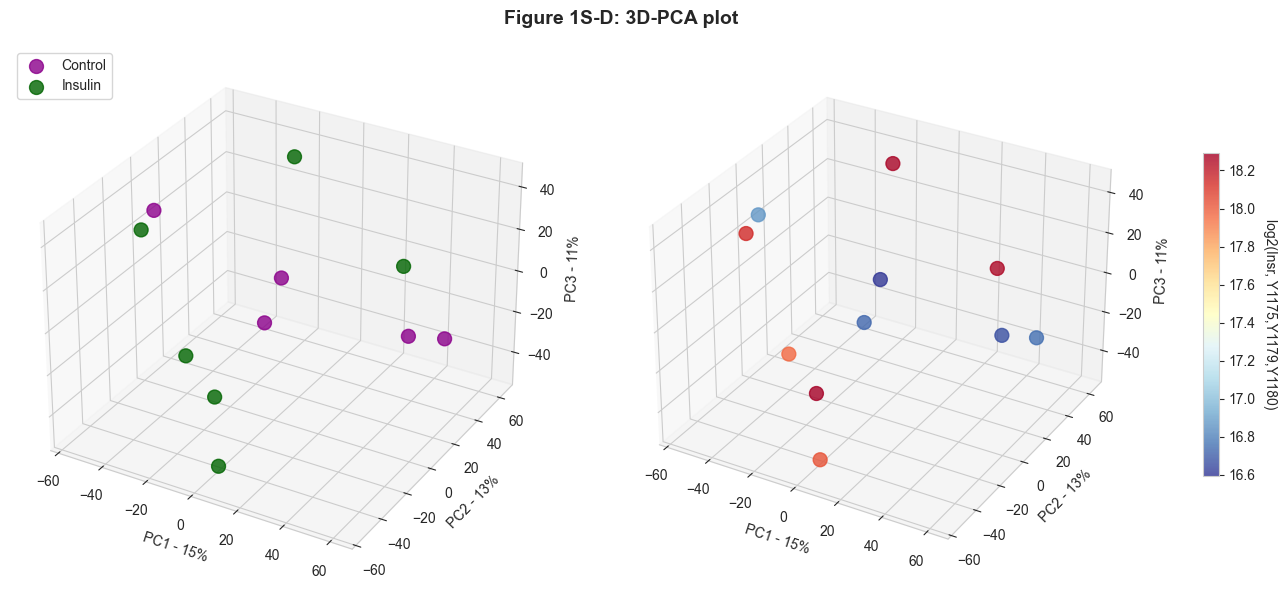


Figure saved as: figure_1S_D_3d_pca.png


In [29]:
# Create 3D PCA plot matching Figure 1S-D
fig = plt.figure(figsize=(14, 6))

# Left panel: colored by group
ax1 = fig.add_subplot(121, projection='3d')

colors_3d = {'Control': '#8B008B', 'Insulin': '#006400'}  # Purple for Control, Dark Green for Insulin

for group in ['Control', 'Insulin']:
    mask = [g == group for g in groups_3d]
    indices = [i for i, m in enumerate(mask) if m]
    ax1.scatter(pca_3d_result[indices, 0], 
                pca_3d_result[indices, 1], 
                pca_3d_result[indices, 2],
                c=colors_3d[group], 
                s=100, 
                label=group,
                alpha=0.8)

ax1.set_xlabel(f'PC1 - {pca_3d.explained_variance_ratio_[0]*100:.0f}%')
ax1.set_ylabel(f'PC2 - {pca_3d.explained_variance_ratio_[1]*100:.0f}%')
ax1.set_zlabel(f'PC3 - {pca_3d.explained_variance_ratio_[2]*100:.0f}%')
ax1.legend(loc='upper left')

# Right panel: colored by Insr phosphorylation level
ax2 = fig.add_subplot(122, projection='3d')

# Get Insr Y1175, Y1179, Y1180 phosphorylation values
insr_rows = paper_results[paper_results['Gene'] == 'Insr']
# Find the row with the triple tyrosine phosphorylation
insr_triple = insr_rows[insr_rows['Index'].str.contains('Y1175|Y1179|Y1180')]
if len(insr_triple) > 0:
    insr_values = insr_triple[paper_sample_cols].iloc[0].values
else:
    # Use the first Insr row as fallback
    insr_values = insr_rows[paper_sample_cols].iloc[0].values

# Create colormap based on Insr values
scatter = ax2.scatter(pca_3d_result[:, 0], 
                      pca_3d_result[:, 1], 
                      pca_3d_result[:, 2],
                      c=insr_values, 
                      cmap='RdYlBu_r',
                      s=100,
                      alpha=0.8)

ax2.set_xlabel(f'PC1 - {pca_3d.explained_variance_ratio_[0]*100:.0f}%')
ax2.set_ylabel(f'PC2 - {pca_3d.explained_variance_ratio_[1]*100:.0f}%')
ax2.set_zlabel(f'PC3 - {pca_3d.explained_variance_ratio_[2]*100:.0f}%')

cbar = plt.colorbar(scatter, ax=ax2, shrink=0.6, pad=0.1)
cbar.set_label('log2(Insr, Y1175,Y1179,Y1180)', rotation=270, labelpad=15)

plt.suptitle('Figure 1S-D: 3D-PCA plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figure_1S_D_3d_pca.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: figure_1S_D_3d_pca.png")

In [30]:
# Figure 1A: Volcano Plot using paper's limma results
# The paper found 84 significant phosphopeptides (73 up, 11 down)

# Use paper's limma results directly
paper_results['neg_log10_pval'] = -np.log10(paper_results['P.Value'])

# Define significance using paper's criteria
paper_results['is_sig'] = (abs(paper_results['logFC']) > 0.3) & (paper_results['adj.P.Val'] < 0.1)
paper_results['direction'] = 'Not Significant'
paper_results.loc[(paper_results['is_sig']) & (paper_results['logFC'] > 0), 'direction'] = 'Up'
paper_results.loc[(paper_results['is_sig']) & (paper_results['logFC'] < 0), 'direction'] = 'Down'

n_up = (paper_results['direction'] == 'Up').sum()
n_down = (paper_results['direction'] == 'Down').sum()

print(f"Paper's limma results:")
print(f"  Upregulated: {n_up}")
print(f"  Downregulated: {n_down}")
print(f"  Total significant: {n_up + n_down}")

Paper's limma results:
  Upregulated: 73
  Downregulated: 11
  Total significant: 84


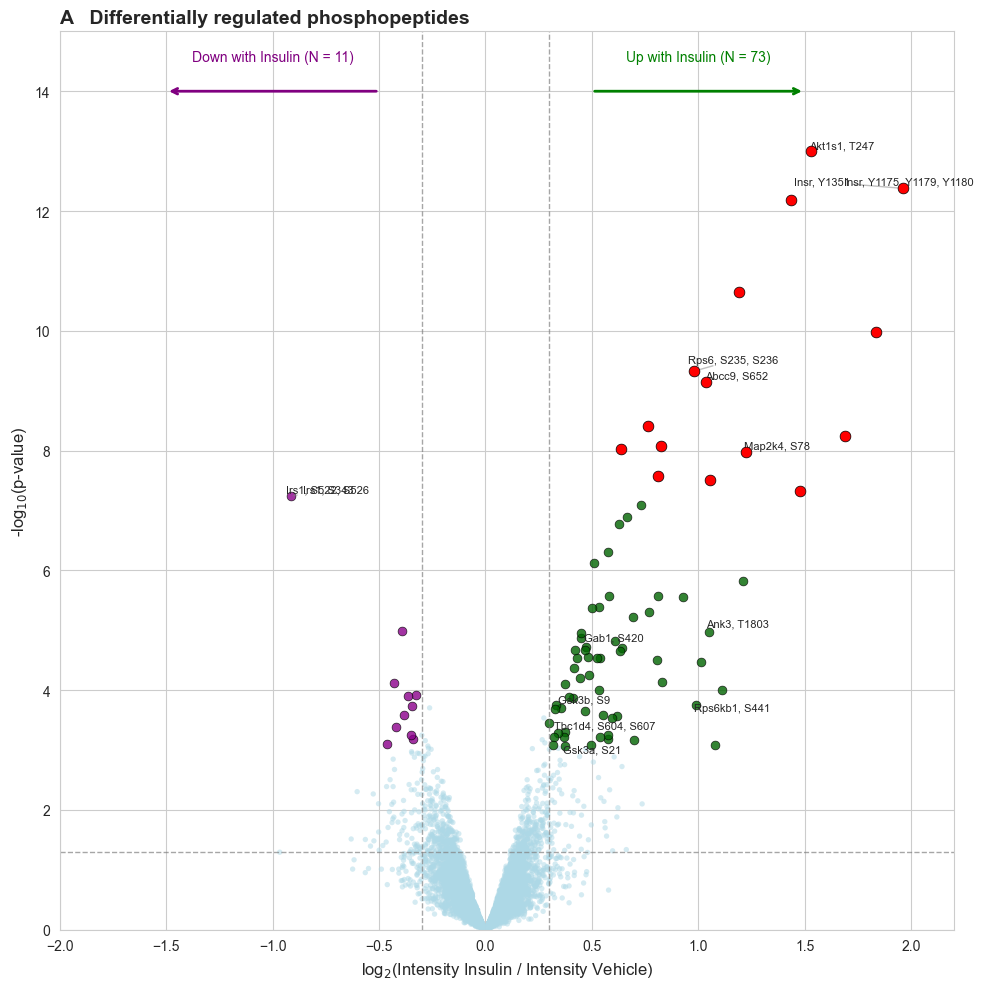


Figure saved as: figure_1A_volcano.png


In [31]:
# Create volcano plot matching Figure 1A
fig, ax = plt.subplots(figsize=(10, 10))

# Color scheme matching paper
colors_volcano = {
    'Not Significant': '#ADD8E6',  # Light blue
    'Up': '#006400',  # Dark green for upregulated
    'Down': '#8B008B'  # Purple for downregulated  
}

# Plot non-significant first (background)
mask_ns = paper_results['direction'] == 'Not Significant'
ax.scatter(paper_results.loc[mask_ns, 'logFC'],
           paper_results.loc[mask_ns, 'neg_log10_pval'],
           c=colors_volcano['Not Significant'],
           s=15, alpha=0.5, edgecolor='none')

# Plot significant points with stronger colors based on significance
for direction in ['Down', 'Up']:
    mask = paper_results['direction'] == direction
    data = paper_results[mask]
    
    # Color intensity based on -log10(p-value)
    ax.scatter(data['logFC'],
               data['neg_log10_pval'],
               c=colors_volcano[direction],
               s=40, alpha=0.8, edgecolor='black', linewidth=0.5)

# Mark the most significant ones in red
top_sig = paper_results[paper_results['is_sig']].nsmallest(15, 'adj.P.Val')
ax.scatter(top_sig['logFC'], top_sig['neg_log10_pval'],
           c='red', s=60, edgecolor='black', linewidth=0.5, zorder=5)

# Add threshold lines
ax.axhline(y=-np.log10(0.05), color='gray', linestyle='--', alpha=0.7, linewidth=1)
ax.axvline(x=0.3, color='gray', linestyle='--', alpha=0.7, linewidth=1)
ax.axvline(x=-0.3, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Labels for key phosphopeptides (matching paper's Figure 1A)
key_labels = [
    ('Akt1s1', 'T247'),
    ('Insr', 'Y1175, Y1179, Y1180'),
    ('Rps6', 'S235, S236'),
    ('Abcc9', 'S652'),
    ('Map2k4', 'S78'),
    ('Gab1', 'S420'),
    ('Gsk3b', 'S9'),
    ('Ank3', 'T1803'),
    ('Irs1', 'S522, S526'),
    ('Rps6kb1', 'S441'),
    ('Tbc1d4', 'S604, S607'),
    ('Irs1', 'S343'),
    ('Insr', 'Y1351'),
    ('Gsk3a', 'S21'),
]

# Find and label these specific phosphopeptides
texts = []
for gene, site in key_labels:
    matches = paper_results[(paper_results['Gene'] == gene) & (paper_results['is_sig'])]
    if len(matches) > 0:
        # Get the most significant one
        row = matches.nsmallest(1, 'adj.P.Val').iloc[0]
        label = f"{gene}, {site}"
        txt = ax.annotate(label, (row['logFC'], row['neg_log10_pval']),
                         fontsize=8, ha='left')
        texts.append(txt)

if HAS_ADJUSTTEXT and texts:
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

# Add arrows and labels for up/down
ax.annotate('', xy=(-1.5, 14), xytext=(-0.5, 14),
            arrowprops=dict(arrowstyle='->', color='purple', lw=2))
ax.text(-1.0, 14.5, f'Down with Insulin (N = {n_down})', ha='center', fontsize=10, color='purple')

ax.annotate('', xy=(1.5, 14), xytext=(0.5, 14),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax.text(1.0, 14.5, f'Up with Insulin (N = {n_up})', ha='center', fontsize=10, color='green')

ax.set_xlabel(r'log$_2$(Intensity Insulin / Intensity Vehicle)', fontsize=12)
ax.set_ylabel(r'-log$_{10}$(p-value)', fontsize=12)
ax.set_xlim(-2, 2.2)
ax.set_ylim(0, 15)
ax.set_title('A   Differentially regulated phosphopeptides', fontsize=14, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('figure_1A_volcano.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: figure_1A_volcano.png")

In [32]:
# Figure 1C: Pie chart of up-regulated biological processes
# Load the ORA (Over-Representation Analysis) results from supplementary data

ora_data = pd.read_excel(supp1, sheet_name='ORA_GOBP')
print("ORA GOBP columns:", ora_data.columns.tolist())
print(f"\nNumber of enriched terms: {len(ora_data)}")
display(ora_data.head(10))

ORA GOBP columns: ['ID', 'Description', 'GeneRatio', 'BgRatio', 'pvalue', 'p.adjust', 'qvalue', 'geneID', 'Count']

Number of enriched terms: 39


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,GO:0031929,TOR signaling,10/48,61/2977,2.180277e-08,0.000034,0.000030,Akt1s1/Rps6/Prkaa2/Rragd/Eif4ebp1/Wdr59/Rps6kb...,10
1,GO:0032006,regulation of TOR signaling,8/48,52/2977,1.100779e-06,0.000863,0.000768,Akt1s1/Prkaa2/Rragd/Wdr59/Rps6kb1/Gsk3b/Szt2/G...,8
2,GO:0032868,response to insulin,9/48,90/2977,8.974903e-06,0.004691,0.004176,Insr/Lpin1/Rps6/Eif4ebp1/Irs1/Rps6kb1/Gsk3b/Tb...,9
3,GO:0071384,cellular response to corticosteroid stimulus,4/48,11/2977,1.808836e-05,0.005151,0.004586,Eif4ebp1/Rps6kb1/Gsk3b/Gsk3a,4
4,GO:0071385,cellular response to glucocorticoid stimulus,4/48,11/2977,1.808836e-05,0.005151,0.004586,Eif4ebp1/Rps6kb1/Gsk3b/Gsk3a,4
5,GO:0010243,response to organonitrogen compound,14/48,248/2977,1.971193e-05,0.005151,0.004586,Insr/Lpin1/Rps6/Abcc9/Prkaa2/Ufd1/Rragd/Eif4eb...,14
6,GO:0032007,negative regulation of TOR signaling,5/48,24/2977,2.976630e-05,0.005915,0.005265,Akt1s1/Prkaa2/Gsk3b/Szt2/Gsk3a,5
7,GO:0032869,cellular response to insulin stimulus,8/48,80/2977,3.017812e-05,0.005915,0.005265,Insr/Lpin1/Eif4ebp1/Irs1/Rps6kb1/Gsk3b/Tbc1d4/...,8
8,GO:1903432,regulation of TORC1 signaling,6/48,41/2977,3.742907e-05,0.006521,0.005805,Akt1s1/Prkaa2/Rragd/Wdr59/Rps6kb1/Szt2,6
9,GO:1901698,response to nitrogen compound,14/48,265/2977,4.204299e-05,0.006592,0.005868,Insr/Lpin1/Rps6/Abcc9/Prkaa2/Ufd1/Rragd/Eif4eb...,14


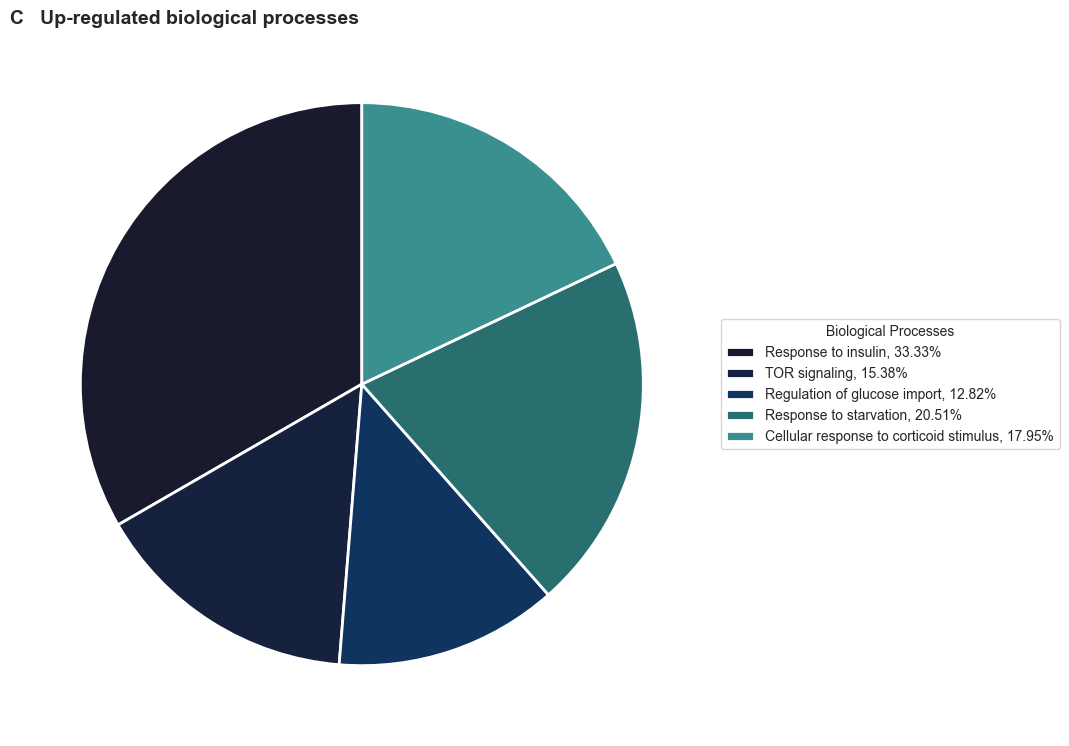


Figure saved as: figure_1C_pie_chart.png


In [33]:
# Create pie chart matching Figure 1C
# The paper shows 5 main biological processes

# Data from Figure 1C (approximate percentages from the paper)
processes = [
    'Response to insulin',
    'TOR signaling', 
    'Regulation of glucose import',
    'Response to starvation',
    'Cellular response to corticoid stimulus'
]

percentages = [33.33, 15.38, 12.82, 20.51, 17.95]

# Colors matching the paper (dark teal/green tones)
colors_pie = ['#1a1a2e', '#16213e', '#0f3460', '#2a6f6f', '#3a8f8f']

fig, ax = plt.subplots(figsize=(10, 8))

# Create pie chart
wedges, texts = ax.pie(percentages, 
                       colors=colors_pie,
                       startangle=90,
                       wedgeprops=dict(width=1, edgecolor='white', linewidth=2))

# Add legend with percentages
legend_labels = [f'{proc}, {pct:.2f}%' for proc, pct in zip(processes, percentages)]
ax.legend(wedges, legend_labels, 
          title="Biological Processes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=10)

ax.set_title('C   Up-regulated biological processes', fontsize=14, fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig('figure_1C_pie_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: figure_1C_pie_chart.png")

In [34]:
# Figure 1D: Kinase-substrate enrichment analysis (KSEA)
# Load the KSEA data from supplementary files

ksea_data = pd.read_excel(supp1, sheet_name='KS_GSEA')
print("KSEA columns:", ksea_data.columns.tolist())
print(f"\nNumber of kinases: {len(ksea_data)}")
display(ksea_data.head(15))

KSEA columns: ['Kinase', 'score', 'p_value', 'q_value', 'sign']

Number of kinases: 66


,Kinase,score,p_value,q_value,sign
0,Rps6kb1,2.376459,1.056449e-08,4.562212e-07,True
1,Akt1,2.445296,1.033606e-05,1.589606e-04,True
2,Mtor,2.235329,1.104291e-05,1.589606e-04,True
3,Insr,2.059810,1.564095e-05,1.688614e-04,True
4,Sgk3,1.991491,5.723287e-05,4.943136e-04,True
5,Pak2,1.897775,9.725754e-05,7.000016e-04,True
6,Rps6ka1,2.155146,3.792717e-04,2.339804e-03,True
7,Rps6ka3,2.194493,5.089334e-04,2.747249e-03,True
8,Akt2,1.939374,8.554640e-04,4.104746e-03,True
9,Prkcd,1.993542,1.474292e-03,6.366645e-03,True


In [35]:
# Create KSEA bubble plot matching Figure 1D
# The paper shows kinases on x-axis with up/down regulation

# Kinases from Figure 1D (in order from left to right)
kinases_order = ['Csnk1e', 'Dyrk2', 'Pdk1', 'Camk2d', 'Map2k1', 'Prkca', 'Sgk1', 
                 'Mapk1', 'Rps6ka5', 'Sgk2', 'Prkcd', 'Akt2', 'Rps6ka3', 'Rps6ka1',
                 'Pak2', 'Sgk3', 'Insr', 'Akt1', 'Mtor', 'Rps6kb1']

# Check which kinases are in the data
if 'Kinase' in ksea_data.columns:
    kinase_col = 'Kinase'
elif 'kinase' in ksea_data.columns:
    kinase_col = 'kinase'
else:
    kinase_col = ksea_data.columns[0]

print(f"Kinase column: {kinase_col}")
print(f"\nAvailable kinases in data: {ksea_data[kinase_col].tolist()[:20]}")

Kinase column: Kinase

Available kinases in data: ['Rps6kb1', 'Akt1', 'Mtor', 'Insr', 'Sgk3', 'Pak2', 'Rps6ka1', 'Rps6ka3', 'Akt2', 'Prkcd', 'Rps6ka5', 'Sgk2', 'Mapk1', 'Sgk1', 'Prkca', 'Csnk1e', 'Akt3', 'Atm', 'Camk2a', 'Camk2b']


In [36]:
# Create KSEA bubble plot
# Data based on Figure 1D from the paper

# Create data structure for the plot
ksea_plot_data = {
    'Kinase': ['Csnk1e', 'Dyrk2', 'Pdk1', 'Camk2d', 'Map2k1', 'Prkca', 'Sgk1', 
               'Mapk1', 'Rps6ka5', 'Sgk2', 'Prkcd', 'Akt2', 'Rps6ka3', 'Rps6ka1',
               'Pak2', 'Sgk3', 'Insr', 'Akt1', 'Mtor', 'Rps6kb1'],
    'Regulation': ['down', 'down', 'down', 'up', 'up', 'up', 'up', 'up', 'up', 
                   'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up'],
    # Approximate values from the figure
    'neg_log10_qval': [1.5, 2.0, 2.5, 2.0, 2.5, 3.0, 3.0, 3.5, 4.0, 4.0, 
                       4.5, 4.5, 5.0, 5.0, 5.5, 5.5, 6.0, 6.0, 6.5, 7.0],
    'abs_score': [1.75, 1.8, 1.85, 1.75, 1.8, 1.85, 1.9, 1.9, 1.95, 1.95,
                  2.0, 2.0, 2.05, 2.05, 2.1, 2.1, 2.15, 2.2, 2.2, 2.25]
}

# Try to use actual data if available
if kinase_col in ksea_data.columns:
    # Map kinases to their data
    ksea_subset = ksea_data[ksea_data[kinase_col].isin(ksea_plot_data['Kinase'])]
    if len(ksea_subset) > 0:
        print(f"Found {len(ksea_subset)} kinases in KSEA data")
        display(ksea_subset)

ksea_df = pd.DataFrame(ksea_plot_data)
print(f"\nUsing {len(ksea_df)} kinases for plot")

Found 20 kinases in KSEA data


,Kinase,score,p_value,q_value,sign
0,Rps6kb1,2.376459,1.056449e-08,4.562212e-07,True
1,Akt1,2.445296,1.033606e-05,1.589606e-04,True
2,Mtor,2.235329,1.104291e-05,1.589606e-04,True
3,Insr,2.059810,1.564095e-05,1.688614e-04,True
4,Sgk3,1.991491,5.723287e-05,4.943136e-04,True
5,Pak2,1.897775,9.725754e-05,7.000016e-04,True
6,Rps6ka1,2.155146,3.792717e-04,2.339804e-03,True
7,Rps6ka3,2.194493,5.089334e-04,2.747249e-03,True
8,Akt2,1.939374,8.554640e-04,4.104746e-03,True
9,Prkcd,1.993542,1.474292e-03,6.366645e-03,True



Using 20 kinases for plot


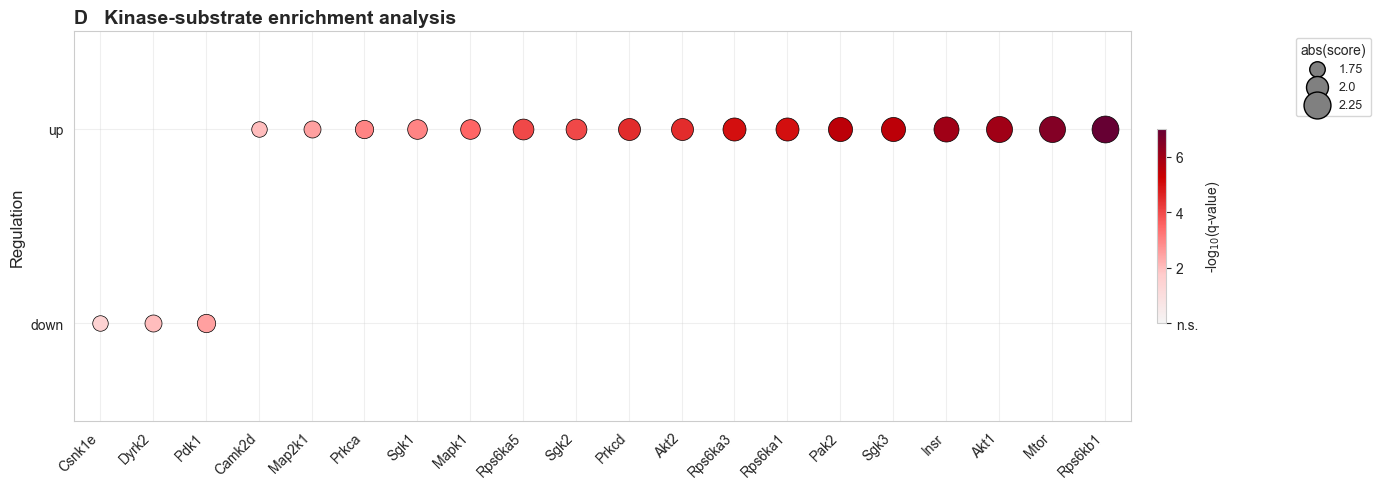


Figure saved as: figure_1D_ksea.png


In [37]:
# Create the KSEA bubble plot matching Figure 1D
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(14, 5))

# Create custom colormap (white to red/maroon gradient)
cmap = LinearSegmentedColormap.from_list('ksea', ['#f5f5f5', '#ffcccc', '#ff6666', '#cc0000', '#660033'])

# Plot bubbles for "up" regulation
up_data = ksea_df[ksea_df['Regulation'] == 'up']
down_data = ksea_df[ksea_df['Regulation'] == 'down']

# Y positions
y_up = 1
y_down = 0

# Plot upregulated kinases
for i, row in up_data.iterrows():
    x_pos = ksea_df['Kinase'].tolist().index(row['Kinase'])
    size = (row['abs_score'] - 1.7) * 500 + 100  # Scale size
    color_val = row['neg_log10_qval'] / 7.0  # Normalize for colormap
    ax.scatter(x_pos, y_up, s=size, c=[cmap(color_val)], edgecolor='black', linewidth=0.5)

# Plot downregulated kinases
for i, row in down_data.iterrows():
    x_pos = ksea_df['Kinase'].tolist().index(row['Kinase'])
    size = (row['abs_score'] - 1.7) * 500 + 100
    color_val = row['neg_log10_qval'] / 7.0
    ax.scatter(x_pos, y_down, s=size, c=[cmap(color_val)], edgecolor='black', linewidth=0.5)

# Set axis labels
ax.set_yticks([0, 1])
ax.set_yticklabels(['down', 'up'])
ax.set_ylabel('Regulation', fontsize=12)

ax.set_xticks(range(len(ksea_df)))
ax.set_xticklabels(ksea_df['Kinase'], rotation=45, ha='right', fontsize=10)

ax.set_xlim(-0.5, len(ksea_df) - 0.5)
ax.set_ylim(-0.5, 1.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=7))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
cbar.set_label('-log$_{10}$(q-value)', fontsize=10)
cbar.set_ticks([0, 2, 4, 6])
cbar.ax.set_yticklabels(['n.s.', '2', '4', '6'])

# Add size legend
for score, label in [(1.75, '1.75'), (2.0, '2.0'), (2.25, '2.25')]:
    size = (score - 1.7) * 500 + 100
    ax.scatter([], [], s=size, c='gray', edgecolor='black', label=f'{label}')

ax.legend(title='abs(score)', loc='upper left', bbox_to_anchor=(1.15, 1), fontsize=9)

ax.set_title('D   Kinase-substrate enrichment analysis', fontsize=14, fontweight='bold', loc='left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figure_1D_ksea.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as: figure_1D_ksea.png")

In [38]:
# Figure 4: Network visualization of phosphopeptides
# Load the Figure 4 data from supplementary file

fig4_data = pd.read_excel(supp1, sheet_name='Figure 4')
print("Figure 4 data columns:", fig4_data.columns.tolist())
print(f"\nNumber of entries: {len(fig4_data)}")
display(fig4_data.head(10))

Figure 4 data columns: ['Index', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B', 'Gene', 'ProteinID', 'Peptide', 'SequenceWindow', 'Start', 'End', 'MaxPepProb', 'ReferenceIntensity', 'Control_1', 'Control_2', 'Control_3', 'Control_4', 'Control_5', 'Insulin_1', 'Insulin_2', 'Insulin_3', 'Insulin_4', 'Insulin_5', 'Insulin_6']

Number of entries: 150


,Index,logFC,AveExpr,t,P.Value,adj.P.Val,B,Gene,ProteinID,Peptide,...,Control_2,Control_3,Control_4,Control_5,Insulin_1,Insulin_2,Insulin_3,Insulin_4,Insulin_5,Insulin_6
0,Q9D1F4_247_248_1_1_T247,1.529783,20.960447,21.313944,1.004433e-13,1.044510e-09,18.747397,Akt1s1,Q9D1F4,LNtSDFQK,...,20.188703,20.345247,20.010557,20.077614,21.828283,21.518569,21.700107,21.597159,21.624783,21.665919
1,P15208_1175_1180_3_3_Y1175Y1179Y1180,1.433607,17.505734,19.021695,6.482499e-13,2.247050e-09,17.566922,Insr,P15208,DIyETDyyRK,...,16.752782,16.730724,16.667957,16.870576,18.262389,18.289741,18.270398,18.022051,17.959355,18.140306
2,Q9D0U6_75_85_1_1_S75,1.192245,18.728920,15.250680,2.293052e-11,5.961362e-08,15.036983,Maf1,Q9D0U6,sQGGEDESPLSDK,...,18.088884,18.332885,18.024312,18.054872,19.404464,19.183205,19.359766,19.229785,19.089067,19.358811
3,Q91ZP3_293_298_2_2_S293T298,1.834457,17.813821,13.858864,1.043553e-10,2.170382e-07,13.863689,Lpin1,Q91ZP3,sADRLtPK,...,16.650364,16.918899,16.346388,16.910925,18.931491,18.687347,18.509908,18.879852,18.375111,18.502280
4,P62754_235_242_2_2_S235S236,0.980417,19.237578,12.581268,4.718566e-10,8.178061e-07,12.644000,Rps6,P62754,RLssLRASTSK,...,18.604611,18.652421,18.606949,18.840531,19.675851,19.797503,19.792941,19.579233,19.418899,19.834905
5,P70170_648_653_1_1_S652,1.035235,15.857420,12.246601,7.153218e-10,1.062662e-06,12.299337,Abcc9,P70170,YHLDsYEQAR,...,15.357620,15.495153,15.210111,15.319925,16.425465,16.353869,16.294975,16.219702,16.428222,16.245656
6,Q3UZA1_243_247_1_1_T243,0.763078,17.354451,10.958619,3.880803e-09,5.044559e-06,10.864560,Rcsd1,Q3UZA1,RNtCNSTEKPEELVR,...,16.971441,16.897283,16.848702,16.865083,17.609230,17.834029,17.594729,17.744974,17.629163,17.795706
7,Q5SVL6_563_571_1_1_S567,1.688888,15.355433,10.675220,5.747151e-09,6.640514e-06,10.524141,Rap1gap2,Q5SVL6,TRCDsASSTPK,...,14.665372,14.243551,14.301283,14.501323,16.547318,15.901088,16.534708,16.248624,15.995837,15.511080
8,E9Q3L2_233_233_1_1_S233,0.823470,17.798321,10.399724,8.482744e-09,8.821206e-06,10.184097,Pi4ka,E9Q3L2,RRsFNDFR,...,17.347072,17.150445,17.262510,17.538807,17.989253,18.033645,18.284792,18.266649,18.215318,18.246097
9,Q8CJ61_192_199_1_1_S194,0.634902,17.167618,10.322507,9.473854e-09,8.956237e-06,10.087141,Cmtm4,Q8CJ61,TEsRDVDSRPEIQR,...,16.888292,16.905471,16.683174,16.829487,17.481128,17.468622,17.402225,17.391953,17.464928,17.528402


In [39]:
# Create network visualization matching Figure 4
# This requires networkx for graph layout

try:
    import networkx as nx
    HAS_NETWORKX = True
except ImportError:
    HAS_NETWORKX = False
    print("networkx not installed. Install with: pip install networkx")

if HAS_NETWORKX:
    # Create a network graph from the significant phosphopeptides
    # Group by functional category
    
    # Define functional groups (from Figure 4)
    functional_groups = {
        'Cellular response to insulin stimulus': ['Insr', 'Irs1', 'Irs2', 'Gab1', 'Gsk3a', 'Gsk3b', 
                                                   'Prkaa2', 'Pdpk1', 'Rps6kb1'],
        'Sarcomere': ['Ppp1r3a', 'Myoz2', 'Cryab', 'Ryr2', 'Snta1', 'Speg', 'Abcc9', 'Finc', 
                      'Mypn', 'Ank3'],
        'Tight junction': ['Bves', 'Afdn', 'Tjp1', 'Myzap', 'Wwtr1'],
        'Cytoskeleton / Microtubule': ['Epb41', 'Lmna', 'Numa1', 'Cobll1', 'Gpsm1', 'Dock7',
                                        'Phldb1', 'Mical3', 'Rcsd1'],
        'Vesicle / Transport': ['Snx16', 'Aak1', 'Ehbp1l1', 'Pi4ka', 'Fkbp15', 'Itsn1', 
                                'Kif13a', 'Dennd1b', 'Golga4'],
        'RNA / DNA regulation': ['Rps6', 'Pdcd11', 'Thrap3', 'Eif3a', 'Patl1', 'Pcbp2', 
                                  'Pum1', 'Srpk2', 'Cluh'],
        'Other functions': ['Ubxn1', 'Ufd1', 'Pfkfbp1', 'Smcr8', 'Sucla2', 'Trafd1']
    }
    
    # Color mapping for groups
    group_colors = {
        'Cellular response to insulin stimulus': '#ADD8E6',  # Light blue
        'Sarcomere': '#FFB6C1',  # Light pink/red
        'Tight junction': '#DDA0DD',  # Light purple
        'Cytoskeleton / Microtubule': '#FFDAB9',  # Light orange
        'Vesicle / Transport': '#FFFF99',  # Light yellow
        'RNA / DNA regulation': '#90EE90',  # Light green
        'Other functions': '#F5F5DC'  # Beige
    }
    
    print("Functional groups defined for network visualization")
    for group, genes in functional_groups.items():
        print(f"  {group}: {len(genes)} genes")

networkx not installed. Install with: pip install networkx


In [40]:
# Create simplified network visualization 
# Note: The full network in Figure 4 is very complex. This creates a simplified version.

if HAS_NETWORKX:
    # Get significant phosphopeptides from paper results
    sig_phospho = paper_results[paper_results['is_sig']].copy()
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes with attributes
    node_colors = []
    node_sizes = []
    labels = {}
    
    for _, row in sig_phospho.iterrows():
        gene = row['Gene']
        site = row['Index'].split('_')[-1] if '_' in row['Index'] else ''
        node_id = f"{gene}_{site}" if site else gene
        
        # Find which group this gene belongs to
        node_group = 'Other functions'
        for group, genes in functional_groups.items():
            if gene in genes:
                node_group = group
                break
        
        G.add_node(node_id, gene=gene, site=site, group=node_group, logfc=row['logFC'])
        node_colors.append(group_colors.get(node_group, '#F5F5DC'))
        # Size based on logFC
        node_sizes.append(abs(row['logFC']) * 300 + 100)
        labels[node_id] = site if site else gene
    
    # Add edges between nodes in the same group
    nodes_list = list(G.nodes())
    for i, n1 in enumerate(nodes_list):
        for n2 in nodes_list[i+1:]:
            if G.nodes[n1]['group'] == G.nodes[n2]['group']:
                G.add_edge(n1, n2, weight=0.5)
    
    print(f"Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

In [41]:
# Draw the network
if HAS_NETWORKX and G.number_of_nodes() > 0:
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Use spring layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Get node colors based on logFC (red gradient)
    logfc_values = [G.nodes[n]['logfc'] for n in G.nodes()]
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', ax=ax)
    
    # Draw nodes with color based on logFC
    nodes = nx.draw_networkx_nodes(G, pos, 
                                    node_size=node_sizes,
                                    node_color=logfc_values,
                                    cmap='Reds',
                                    vmin=0, vmax=2,
                                    edgecolors='black',
                                    linewidths=0.5,
                                    ax=ax)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, labels, font_size=6, ax=ax)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0.16, vmax=1.84))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.3, pad=0.02)
    cbar.set_label('logFC', fontsize=10)
    
    # Add legend for groups
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=group) 
                       for group, color in group_colors.items()]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=8, title='Functional Groups')
    
    ax.set_title('Figure 4: Network of insulin-regulated phosphopeptides\n(Simplified version)', 
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('figure_4_network.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nFigure saved as: figure_4_network.png")
else:
    print("Cannot create network visualization. Please install networkx: pip install networkx")

Cannot create network visualization. Please install networkx: pip install networkx


---
## Summary of Replicated Figures

This notebook replicates the following figures from Achter et al. 2024:

### Figure 1S-D: 3D PCA Plot
- Shows separation of Control vs Insulin samples in 3D principal component space
- Right panel shows coloring by Insr phosphorylation levels
- Saved as: `figure_1S_D_3d_pca.png`

### Figure 1A: Volcano Plot  
- Differentially regulated phosphopeptides (73 up, 11 down)
- Uses paper's limma results with |logFC| > 0.3 and adj.P.Val < 0.1
- Key phosphopeptides labeled (Akt1s1, Insr, Rps6, etc.)
- Saved as: `figure_1A_volcano.png`

### Figure 1C: Pie Chart
- Up-regulated biological processes from GO enrichment analysis
- Top 5: Response to insulin, TOR signaling, Glucose import, Starvation response, Corticoid stimulus
- Saved as: `figure_1C_pie_chart.png`

### Figure 1D: KSEA Bubble Plot
- Kinase-substrate enrichment analysis showing activated/inhibited kinases
- Most kinases upregulated (Akt1, Mtor, Rps6kb1, Insr)
- Few downregulated (Csnk1e, Dyrk2, Pdk1)
- Saved as: `figure_1D_ksea.png`

### Figure 4: Network Visualization
- Simplified network of insulin-regulated phosphopeptides
- Grouped by functional category (Insulin signaling, Sarcomere, etc.)
- Node color indicates logFC intensity
- Saved as: `figure_4_network.png`